In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from monai.config import print_config
from monai.transforms import LoadImage
import monai

print_config()

d:\repos\tdt17_mini_project\venv\lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: d:\repos\tdt17_mini_project\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For d

image data shape: torch.Size([1, 512, 512, 75])
meta data: dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', affine, original_affine, 'as_closest_canonical', spatial_shape, space, original_channel_dim, 'filename_or_obj'])


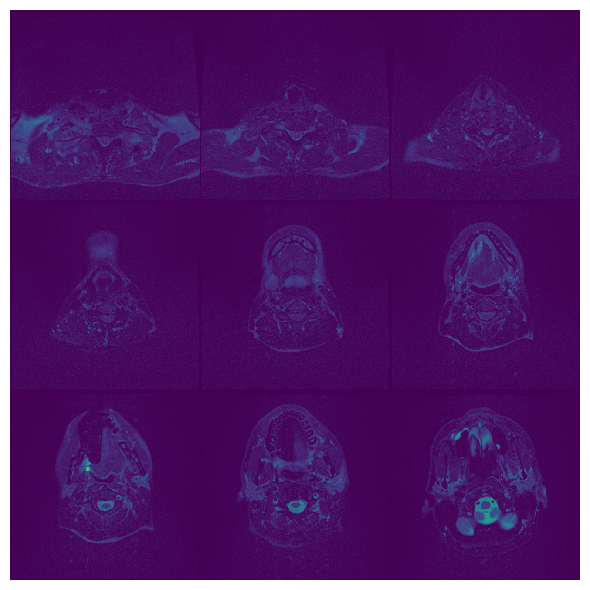

In [3]:
filename = "data/test/29/preRT/29_preRT_T2.nii.gz"
filename_mask = "data/test/29/preRT/29_preRT_mask.nii.gz"

data = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename)
mask = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename_mask)
print(f"image data shape: {data.shape}")
print(f"meta data: {data.meta.keys()}")
mask = mask > 0

masked_data = data + mask*255

monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(masked_data), every_n=9, figsize= (6, 6))
plt.show()


In [4]:
data.meta

{'sizeof_hdr': array(348),
 'extents': array(0),
 'session_error': array(0, dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(16, dtype=int16),
 'bitpix': array(32, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(2, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'slice_duration': array(0., dtype=float32),
 'toffset': array(0., dtype=float32),
 'glmax': array(0),
 'glmin': array(0),
 'qform_code': array(1, dtype=int16),
 'sform_code': array(1, dtype=int16),
 affine: tensor([[  -0.5000,    0.0000,    0.0000,  122.0678],
         [   0.0000,   -0.5000

In [5]:
from data import create_dataset_dicts
from monai.data import Dataset
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    Compose, 
    Resized, 
    Spacingd,
    ToTensord,
    SpatialPadd,
    ToDeviced,
    SelectItemsd,
    NormalizeIntensityd,
    AsDiscreted,
    RandSpatialCropd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    MapTransform,
    AsDiscreted
)

device = "cuda"
data_dicts = create_dataset_dicts("data/train")
train_transforms = Compose(
    [      
        # Load data
        LoadImaged(keys=["image", "mask"]),
        SelectItemsd(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),

        # Normalization and cropping
        RandSpatialCropd(keys=["image", "mask"], roi_size=[256, 256, 80], random_size=False),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),

        # Ensure correct size
        Resized(
            keys=["image", "mask"],
            spatial_size=(256, 256, 80),
            mode=("bilinear", "nearest"),
        ),
    ]
)

# train_transforms = Compose(
#     [
#         # Load data
#         LoadImaged(keys=["image", "mask"]),
#         SelectItemsd(keys=["image", "mask"]),
#         EnsureChannelFirstd(keys=["image", "mask"]),
#         # Normalization and resizing
#         NormalizeIntensityd(keys="image"),
#         Resized(
#             keys=["image", "mask"],
#             spatial_size=(256, 256, 80),
#             mode=("bilinear", "nearest"),
#         ),
#         RandRotate90d(keys=["image", "mask"], prob=0.5, spatial_axes=(0, 1)),
#         ToDeviced(keys=["image", "mask"], device=device),
#     ]
# )
dataset = Dataset(data_dicts, train_transforms)
dataset[0]['image'].shape, dataset[0]['mask'].shape

(torch.Size([1, 256, 256, 80]), torch.Size([1, 256, 256, 80]))

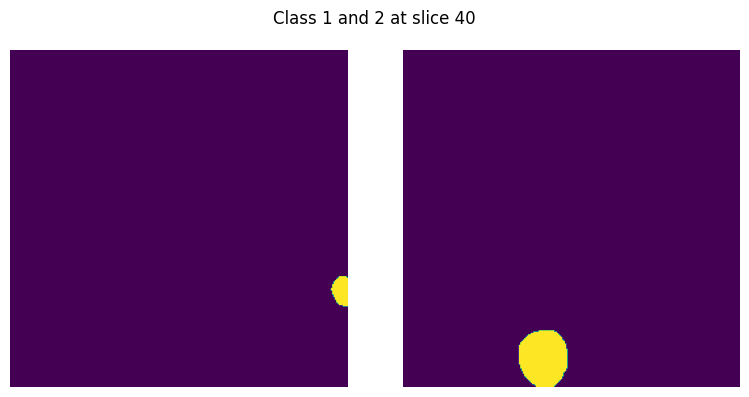

In [6]:
# Visualization of two classes at slice 40
fig, ax = plt.subplots(1,2, figsize=(8,4))
[a.axis('off') for a in ax]
ax[0].imshow(dataset[0]['mask'][0,:,:,40].eq(1).cpu())
ax[1].imshow(dataset[0]['mask'][0,:,:,40].eq(2).cpu())
fig.suptitle("Class 1 and 2 at slice 40")
fig.tight_layout();

In [7]:
test_transforms = Compose(
    [      
        # Load data
        LoadImaged(keys=["image", "mask"]),
        SelectItemsd(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),

        # Normalization and resizing
        NormalizeIntensityd(keys="image"),
        Resized(keys=["image", "mask"], spatial_size=(256, 256, 80), mode=("bilinear", "nearest")),
        ToDeviced(keys=["image", "mask"], device=device),
    ]
)
data_dicts_test = create_dataset_dicts("data/test")
test_dataset = Dataset(data_dicts_test, test_transforms)

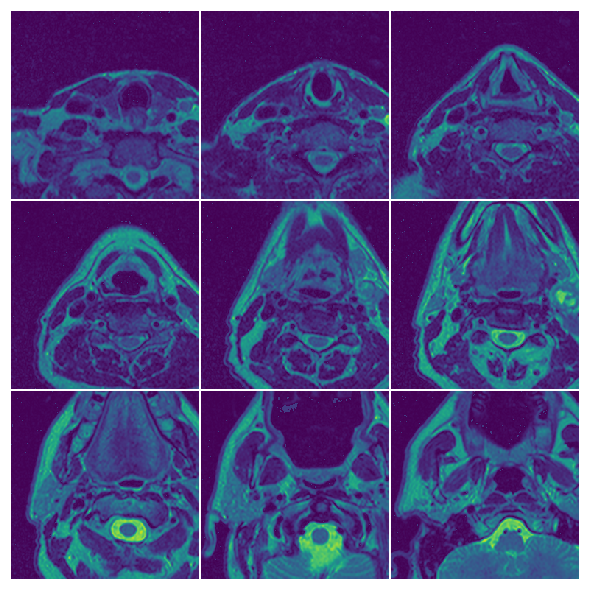

In [8]:
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(dataset[0]['image']), every_n=9, figsize= (6, 6))
plt.show()

In [9]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

In [10]:
from monai.data import DataLoader
from tqdm import tqdm
from monai.data import create_test_image_3d, list_data_collate, pad_list_data_collate
batch_size = 2

loader = DataLoader(dataset, batch_size=batch_size)
e = 0
losses = []

In [11]:
# Training loop
import monai.optimizers
import time

epochs = 30
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
loss_function = monai.losses.DiceCELoss(include_background=False, softmax=True, to_onehot_y=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
for e in range(e, epochs + e):
    print(f"Epoch: {e}")
    time.sleep(0.1)
    model.train()
    for batch in tqdm(loader, desc="Training step"):
        inputs, labels = batch['image'].to(device), batch['mask'].to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_function(preds, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    lr_scheduler.step()
    print(f"Loss: {np.mean(losses[-130:])}")
e += 1

Epoch: 0


Training step:  20%|██        | 13/65 [00:19<01:18,  1.52s/it]


KeyboardInterrupt: 

In [12]:
from scipy.signal import savgol_filter

plt.plot(savgol_filter(losses, 250, 3), color="red", alpha=1.0)
plt.plot(losses, color="green", alpha=0.3)
plt.title("Training loss")
plt.xlabel("Training step")
plt.ylabel("Dice loss");

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [13]:
from monai.metrics import DiceMetric 

dice_metric = DiceMetric(include_background=False, reduction="mean", num_classes=3)

test_loader = DataLoader(test_dataset, batch_size=1)
for batch in tqdm(test_loader, desc="Testing steps"):
    inputs, labels = batch['image'], batch['mask']

    logits = model(inputs)
    preds = logits#.softmax(1).argmax(1)

    dice_metric(y_pred=preds, y=labels)
    
dice_score = dice_metric.aggregate().item()
print(f"Dice score: {dice_score:.3f}")
dice_metric.reset()

Testing steps:  30%|███       | 6/20 [00:04<00:09,  1.48it/s]


KeyboardInterrupt: 

In [14]:
pred = model(test_dataset[0]['image'].unsqueeze(0))
pred.softmax(1).argmax(1).shape

torch.Size([1, 256, 256, 80])

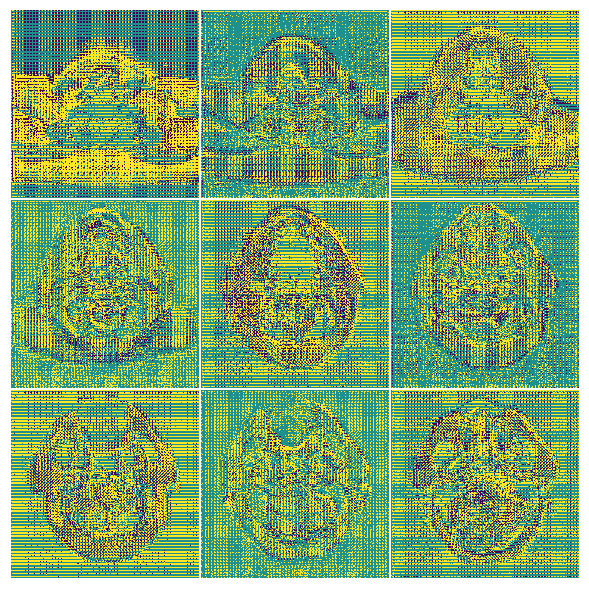

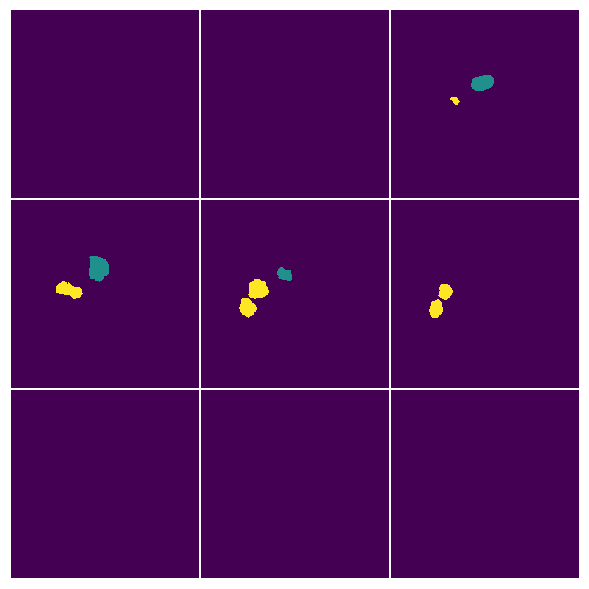

In [29]:
sample = test_dataset[15]
pred = model(sample['image'].unsqueeze(0))
pred = pred.softmax(1).argmax(1)
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(pred), every_n=9, figsize=(6,6))
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(sample['mask']), every_n=9, figsize=(6,6));